# Bangalore House price prediction 

The data has been taken from MachineHack and below is the link to the data
https://www.machinehack.com/hackathons/predicting_house_prices_in_bengaluru/overview

There are 9 features and each feature can be accessed by its name.

Features 

Area_type - describes the area 

Availability - when it can be possessed or when it is ready(in the year 2020)(categorical and time-series) 

Location - where it is located in Bengaluru 

Price - Value of the property in lakhs(INR) 

Size - in BHK or Bedroom (1-10 or more) 

Society - to which society it belongs

Total_sqft - size of the property in sq.ft 

Bath - No. of bathrooms 

Balcony - No. of the balcony 

The data has 13320 Observations

We will be using various machine learning models to predict the prices of houses in the bangalore 

#  Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import stats
from scipy import stats,special
from sklearn.model_selection import cross_val_score

C:\Users\vivji\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\vivji\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
data=pd.read_csv('Train.csv')

In [3]:
data['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

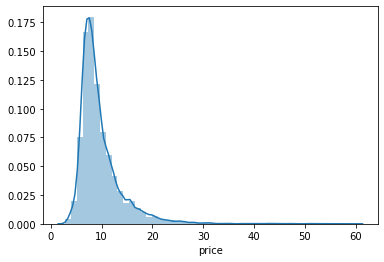

In [4]:
sns.distplot(np.sqrt(data['price']))

In [5]:
data['price']

0         39.07
1        120.00
2         62.00
3         95.00
4         51.00
          ...  
13315    231.00
13316    400.00
13317     60.00
13318    488.00
13319     17.00
Name: price, Length: 13320, dtype: float64

## Data

Categorical Variables- area_type,Availability(Few entries have time series values),Location,Society

Numerical Variables- size,total_sqft,bath,balcony

Target variable-Price

# Cleaning data
Cleaning the data is necessary before further analysis are few columns have issues with the formatting

## Availability

The Availability column has the dates when the house will be ready to move or if they are available for immediate possession.
As all data is for 2020 for all the values,we will only consider the months of the year. The houses which are ready to move have been given availability value as zero.

In [6]:
#keeping only month values. zero for ready to move
data['availability']=data['availability'].apply(lambda x:x[3:6])

In [7]:
data['availability']

0        Dec
1        dy 
2        dy 
3        dy 
4        dy 
        ... 
13315    dy 
13316    dy 
13317    dy 
13318    Jun
13319    dy 
Name: availability, Length: 13320, dtype: object

In [8]:
data['availability']=data['availability'].map({'Dec':12, 'dy ':0, 'May':5, 'Feb':2, 'Nov':11, 'Oct':10, 'Sep':9, 'Mar':3, 'Apr':4,
       'Aug':8, 'Jun':6, 'Jan':1, 'Jul':7, 'edi':0})

In [9]:
data['availability'].apply(lambda x:type(x)).value_counts()

<class 'int'>    13320
Name: availability, dtype: int64

In [10]:
avai_str=data[data['availability'].apply(lambda x:isinstance(x,str))]
avai_index=avai_str[avai_str==1].index
for i in avai_index:
    data.loc[i,'availability']=float(data.loc[i,'availability'])

In [11]:
data['availability']=data['availability'].apply(lambda x:float(x))

In [12]:
data['availability'].value_counts()/data['availability'].count()*100

0.0     79.557057
12.0     5.465465
5.0      2.537538
4.0      2.237237
8.0      1.869369
3.0      1.846847
7.0      1.546547
6.0      1.501502
1.0      0.945946
10.0     0.683183
9.0      0.653153
11.0     0.593093
2.0      0.563063
Name: availability, dtype: float64

Around 80 percent of the houses are ready to move

## Size

the size varaible tells the number of bedrooms in the house. The variables needs some formating as it is a mix of int and string values

In [13]:
#taking the integer values in the variable
data['size']=data['size'].apply(lambda x:str(x)[0:2])

In [14]:
data['size'].value_counts()

2     5528
3     4857
4     1417
1      656
5      356
6      221
7      100
8       89
9       54
na      16
10      14
11       4
43       1
12       1
27       1
19       1
13       1
18       1
14       1
16       1
Name: size, dtype: int64

In [15]:
data['size'].mode()

0    2 
dtype: object

In [16]:
#replacing null values with mode
data[data['size']=='na']='2'

In [17]:
data['size'].unique()

array(['2 ', '4 ', '3 ', '6 ', '1 ', '8 ', '7 ', '5 ', '11', '9 ', '2',
       '27', '10', '19', '16', '43', '14', '12', '13', '18'], dtype=object)

In [18]:
#coverting to integers
data['size']=data['size'].apply(lambda x:float(x))

## Bath and Balcony

In [19]:
#making sure all values are floats
data['bath']=data['bath'].apply(lambda x:float(x))
data['balcony']=data['balcony'].apply(lambda x:float(x))

filling mode values

In [20]:
data['bath'].mode()

0    2.0
dtype: float64

In [21]:
data['balcony'].mode()

0    2.0
dtype: float64

In [22]:
data['bath'].fillna(2.0,inplace=True)
data['balcony'].fillna(2.0,inplace=True)

## Location and society

In [23]:
#filling missing values of location and society with 'Unknown'
data['location'].fillna('unknown',inplace=True)
data['society'].fillna('unknown',inplace=True)

## total_sqft

This could be one of the most important variables in predicting the housing prices. The total_sqft varaible has few alphanumeric valyes like 'S13k'.These need to be removed to further explore the data

In [24]:
data['total_sqft']=data['total_sqft'].apply(lambda x:x[0:4])
alphanum=1-data['total_sqft'].apply(lambda x:x.isdecimal()) #checking for alphanumeric
alpha_index=alphanum[alphanum==1].index #indices of all such alphanumeric values

In [25]:
data.iloc[alpha_index]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
410,Super built-up Area,0,Kengeri,1.0,unknown,34.4,1.0,0.0,18.5
886,Super built-up Area,6,Chandapura,1.0,SuVue S,520,1.0,0.0,15.135
959,Super built-up Area,0,Kammasandra,1.0,Puitea,650,1.0,0.0,18.41
990,Super built-up Area,0,Sarjapur,1.0,DSousyl,633,1.0,0.0,17.535
1019,Plot Area,3,Marathi Layout,1.0,unknown,5.31,1.0,0.0,110
...,...,...,...,...,...,...,...,...,...
12252,Built-up Area,0,Gowdanapalya,5.0,unknown,24Sq,5.0,0.0,75
12334,Super built-up Area,6,Budigere,1.0,Brstaue,650,1.0,0.0,34.545
12560,Super built-up Area,12,Hosa Road,3.0,Sosisic,142.,3.0,1.0,110
12652,Plot Area,0,Billamaranahalli,2.0,AWharan,300S,2.0,2.0,150


In [26]:
#creating checkpoint
data_checkpoint=data

In [27]:
#dropping rows with aplhanumeric values
data.drop(alpha_index,inplace=True)

In [28]:
#converting to float
data['total_sqft']=data['total_sqft'].apply(lambda x:float(x))

## price

In [29]:
#price variable has few string values
data['price'].apply(lambda x:type(x)).value_counts()

<class 'float'>    13200
<class 'str'>         16
Name: price, dtype: int64

In [30]:
is_str=1-data['price'].apply(lambda x:isinstance(x,float)) #checking for string values

In [31]:
str_index=is_str[is_str==1].index #indices of string values

In [32]:
str_index

Int64Index([  579,  1775,  2264,  2809,  2862,  5333,  6423,  6636,  6719,
             7680,  8306,  8565,  8703, 10634, 11019, 11569],
           dtype='int64')

In [33]:
check=data #checkpoint

In [34]:
for i in str_index:
    data.loc[i,'price']=float(data.loc[i,'price'])

In [35]:
data['price'].apply(lambda x:type(x)).value_counts()

<class 'float'>    13216
Name: price, dtype: int64

In [36]:
data['price']=data['price'].apply(lambda x:float(x))

In [37]:
data['price']

0         39.07
1        120.00
2         62.00
3         95.00
4         51.00
          ...  
13315    231.00
13316    400.00
13317     60.00
13318    488.00
13319     17.00
Name: price, Length: 13216, dtype: float64

The price variable is clean now

In [38]:
data['availability']=data['availability'].apply(lambda x:float(x))

In [39]:
area_ind=data[data['area_type']=='2'].index
data.drop(index=area_ind,inplace=True)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13200 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13200 non-null  object 
 1   availability  13200 non-null  float64
 2   location      13200 non-null  object 
 3   size          13200 non-null  float64
 4   society       13200 non-null  object 
 5   total_sqft    13200 non-null  float64
 6   bath          13200 non-null  float64
 7   balcony       13200 non-null  float64
 8   price         13200 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.0+ MB


All the variable are in desired format and desired data types.The variable area_type does not need any pre-processing. The data is clean now

# Exploring the data

##  price

Text(0.5, 0, "price(in '0000)")

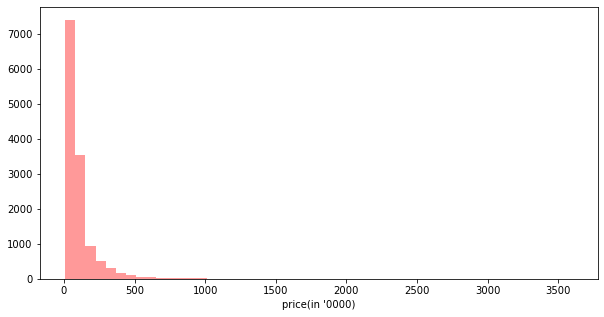

In [41]:
plt.figure(figsize=(10,5))

sns.distplot(data['price'],bins=50,kde=False,color='red')
plt.xlabel("price(in '0000)")

In [42]:
data['price'].describe()

count    13200.000000
mean       112.876491
std        149.332878
min          8.000000
25%         50.000000
50%         72.000000
75%        120.000000
max       3600.000000
Name: price, dtype: float64

In [43]:
data[data['price']>500]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
7,Super built-up Area,0.0,Rajaji Nagar,4.0,Brway G,3300.0,4.0,2.0,600.0
62,Plot Area,0.0,Whitefield,4.0,Chranya,5700.0,5.0,3.0,650.0
159,Plot Area,0.0,Mahalakshmi Layout,4.0,unknown,3750.0,4.0,0.0,760.0
408,Super built-up Area,1.0,Rajaji Nagar,7.0,unknown,1200.0,6.0,3.0,2200.0
440,Plot Area,0.0,Whitefield,4.0,unknown,1189.0,4.0,3.0,700.0
...,...,...,...,...,...,...,...,...,...
13095,Super built-up Area,0.0,Sathya Sai Layout,4.0,Prowshi,6652.0,6.0,1.0,660.0
13104,Built-up Area,12.0,Church Street,4.0,CoDast,2920.0,4.0,3.0,536.0
13119,Plot Area,0.0,Sathya Sai Layout,4.0,Prowshi,6688.0,6.0,1.0,700.0
13197,Plot Area,0.0,Ramakrishnappa Layout,4.0,unknown,9200.0,4.0,2.0,2600.0


240 houses have prices more than 5 crores

The distribution is heavily skewed with a long tail to the right(positively skewed).Most of the housing prices roughly lie below the 50 lakhs range.75 percent of the houses have prices below 1.2 crore.the prices start from 2 lakhs and go upto 36 crore

# Total Sqaure foot

In [44]:
#plots with unsual areas 

In [45]:
data[(data['area_type']=='Plot  Area') & (data['total_sqft']>7000)]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
514,Plot Area,0.0,Banashankari Stage III,4.0,unknown,8500.0,4.0,2.0,145.0
1590,Plot Area,0.0,Kengeri,5.0,unknown,8000.0,5.0,2.0,500.0
2108,Plot Area,0.0,Kothanur,5.0,unknown,9600.0,5.0,2.0,550.0
4243,Plot Area,3.0,Hunasamaranahalli,4.0,EmardBo,7500.0,4.0,2.0,900.0
4799,Plot Area,0.0,Bannerghatta Road,3.0,unknown,9000.0,4.0,1.0,390.0
8546,Plot Area,0.0,Dollars Colony,3.0,unknown,7800.0,3.0,2.0,2000.0
8682,Plot Area,0.0,Yemlur,4.0,Epllan,8400.0,5.0,2.0,1675.0
9347,Plot Area,0.0,Ramagondanahalli,5.0,Adion A,9600.0,6.0,1.0,1800.0
9804,Plot Area,0.0,Shetty Halli,5.0,unknown,8000.0,5.0,3.0,550.0
10429,Plot Area,0.0,Cunningham Road,4.0,unknown,7500.0,6.0,2.0,1800.0


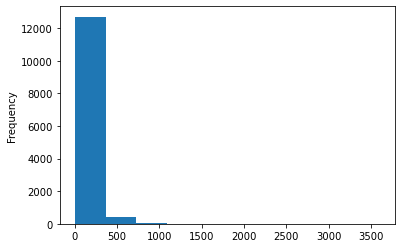

In [46]:
data['price'].plot(kind='hist')

## size and bath

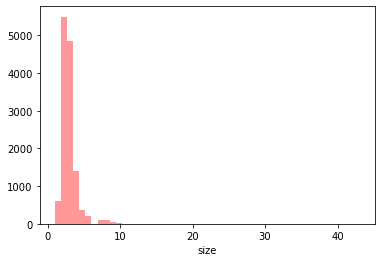

In [47]:
sns.distplot(data['size'],kde=False,color='red')

In [48]:
data[data['size']>15]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
1718,Super built-up Area,0.0,2Electronic City Phase II,27.0,unknown,8000.0,27.0,0.0,230.0
3379,Super built-up Area,0.0,1Hanuman Nagar,19.0,unknown,2000.0,16.0,2.0,490.0
3609,Super built-up Area,0.0,Koramangala Industrial Layout,16.0,unknown,1000.0,16.0,2.0,550.0
4684,Plot Area,0.0,Munnekollal,43.0,unknown,2400.0,40.0,0.0,660.0
11559,Plot Area,4.0,1Kasavanhalli,18.0,HMwerCo,1200.0,18.0,2.0,200.0


few houses have really high number of bedroom and bathrooms. This could be luxury housing projects

In [49]:
data.corr()

,availability,size,total_sqft,bath,balcony,price
availability,1.000000,-0.087877,-0.032094,-0.067803,-0.100785,-0.047995
size,-0.087877,1.000000,0.448248,0.894904,0.186222,0.396720
total_sqft,-0.032094,0.448248,1.000000,0.517298,0.211277,0.662782
bath,-0.067803,0.894904,0.517298,1.000000,0.200788,0.453333
balcony,-0.100785,0.186222,0.211277,0.200788,1.000000,0.121523
price,-0.047995,0.396720,0.662782,0.453333,0.121523,1.000000


there is good amount of positive linear co-relation between total_sqft and price of the house. 
there is a really high co-relation between number of bedroom and bathroom. 

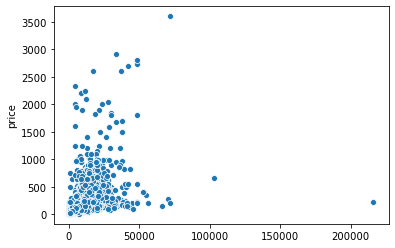

In [50]:
sns.scatterplot(data['size']*data['total_sqft'],data['price'])

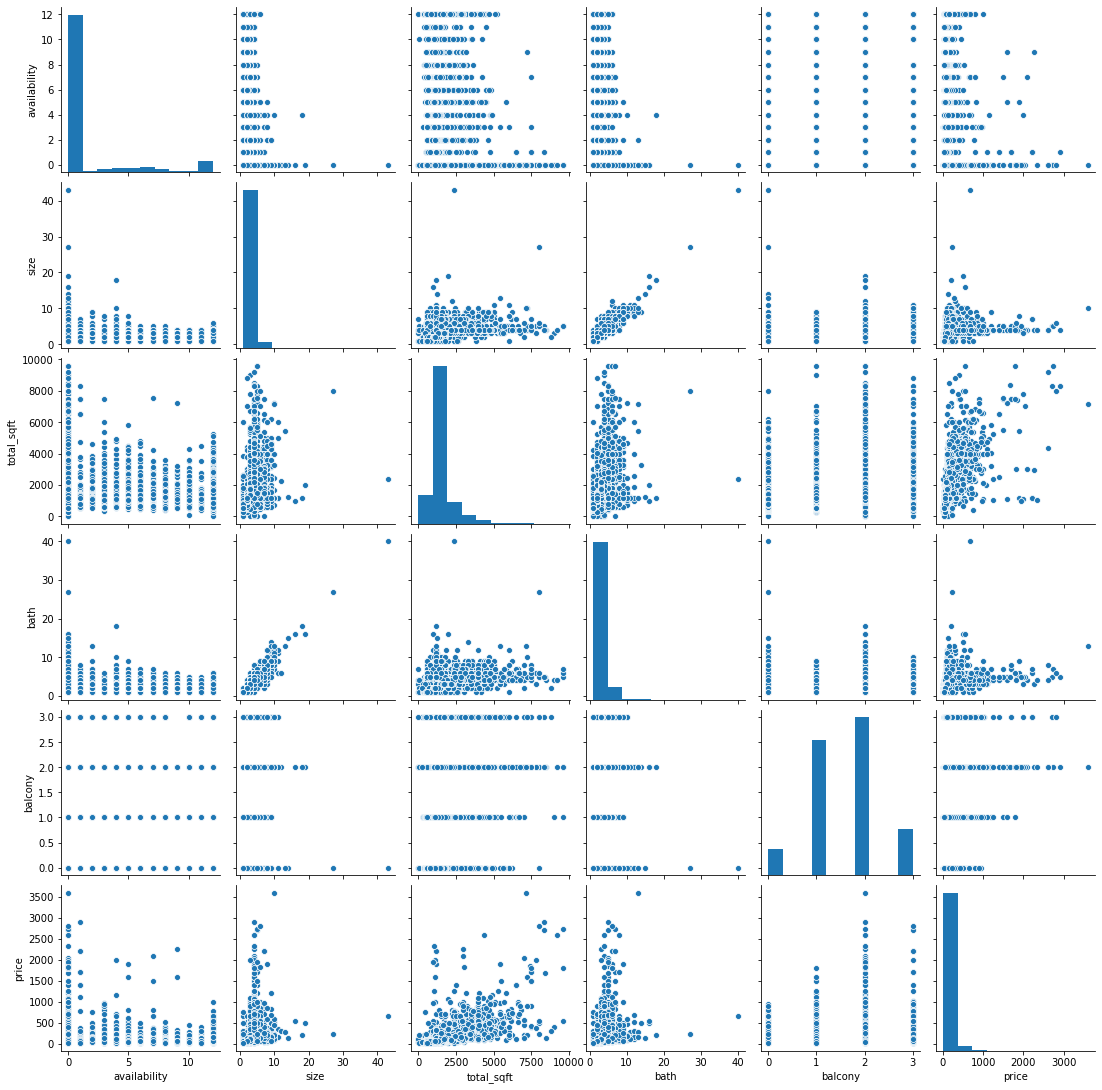

In [51]:
sns.pairplot(data[['availability','size', 'total_sqft', 'bath', 'balcony', 'price']])

## Finding skew of each variable after tranformation to find the right tranformation

In [52]:
def skew(x):
    a=stats.skew(np.log(data[x]))
    b=stats.skew(np.sqrt(data[x]))
    c=stats.skew(np.sqrt(data[x]))
    return (a,b,c)

In [53]:
def skew_zero(x):
    a=stats.skew(np.log(0.00001+data[x]))
    b=stats.skew(np.sqrt(data[x]))
    c=stats.skew(np.sqrt(data[x]))
    return (a,b,c)

In [54]:
skew('price')

(0.8412338469407193, 2.8824914078665733, 2.8824914078665733)

In [55]:
skew('total_sqft')

(-0.21080691046834008, 1.6416386001105794, 1.6416386001105794)

In [56]:
skew('size')

(0.22181856619826634, 1.4764893276565991, 1.4764893276565991)

In [57]:
skew('bath')

(0.44754717685776096, 1.5580702439677638, 1.5580702439677638)

In [58]:
skew_zero('balcony')

(-3.1992622090848566, -1.4263239635293783, -1.4263239635293783)

In [59]:
skew_zero('availability')

(1.4938608736446524, 1.770783220860243, 1.770783220860243)

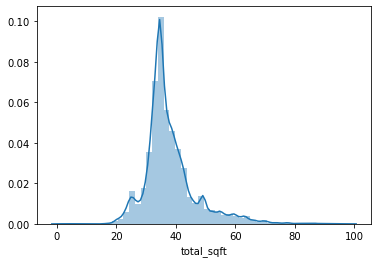

In [60]:
sns.distplot(np.sqrt(data['total_sqft']))

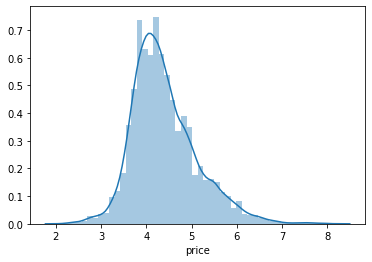

In [61]:
sns.distplot(np.log(data['price']))

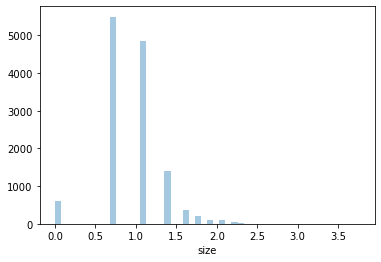

In [62]:
sns.distplot(np.log(data['size']),kde=False)

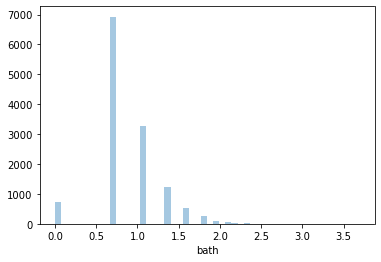

In [63]:
sns.distplot(np.log(data['bath']),kde=False)

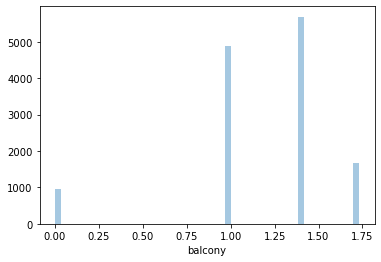

In [64]:
sns.distplot(np.sqrt(data['balcony']),kde=False)

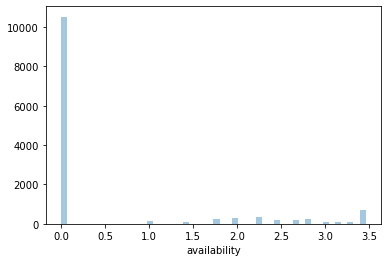

In [65]:
sns.distplot(np.sqrt(data['availability']),kde=False)

# Getting dummy varaibles

In [66]:
data_dummy=pd.get_dummies(data,prefix_sep="@",columns=['area_type','society','location'],drop_first=True)

In [67]:
X=data_dummy.drop('price',axis=1)
y=pd.Series(data_dummy['price'])

# Transforming varaibles for normality

In [68]:
X['total_sqft']=np.sqrt(data['total_sqft'])
X['size']=np.log(data['size'])
X['availability']=np.sqrt(data['availability'])
X['bath']=np.log(data['bath'])
X['balcony']=np.sqrt(data['balcony'])

In [69]:
#availability and balcony has zero values and thus sqrt tranformation has been used 

# Train test split

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scaling and normalization

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
ss=StandardScaler()

In [73]:
X_train_scaled=ss.fit_transform(X_train)

In [74]:
X_test_scaled=ss.transform(X_test)

# Applying ML Algorithm- Linear regression

In [75]:
from sklearn.linear_model import LinearRegression

In [76]:
lr=LinearRegression()

In [77]:
lr.fit(X_train_scaled,y_train)

LinearRegression()

In [78]:
lr_pred=lr.predict(X_test_scaled)

In [79]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [80]:
from sklearn.metrics import r2_score,mean_squared_error

In [81]:
MAPE(y_test,lr_pred)

1346036852182241.5

In [82]:
np.sqrt(mean_squared_error(y_test,lr_pred))

6069035731829101.0

In [83]:
r2_score(y_test,lr_pred)

-1.627816509707259e+27

The results given by limear regression are really bad. This could be because a the relationship between the price variable and the explanatory varaible could be curvilinear. Let us try Polynomial regresssion to see if we can improve accuracy.

# Linear regression with polynomials

In [84]:
X=data.drop(['price','area_type','society','location'],axis=1)
y=pd.Series(data['price'])

In [85]:
from sklearn.preprocessing import PolynomialFeatures

In [86]:
poly_2=PolynomialFeatures(2)

In [87]:
X_poly=poly_2.fit_transform(X)

In [88]:
cats=pd.get_dummies(data,prefix_sep="@",columns=['area_type','society','location'],drop_first=True).drop(['availability', 'size',
       'total_sqft', 'bath', 'balcony', 'price'],axis=1)


In [89]:
pd.DataFrame(X_poly).shape

(13200, 21)

In [90]:
cats.shape

(13200, 3961)

In [91]:
X_poly.shape

(13200, 21)

In [92]:
#X=np.hstack((cats,X_poly))

In [93]:
X.shape

(13200, 5)

In [94]:
X

,availability,size,total_sqft,bath,balcony
0,12.0,2.0,1056.0,2.0,1.0
1,0.0,4.0,2600.0,5.0,3.0
2,0.0,3.0,1440.0,2.0,3.0
3,0.0,3.0,1521.0,3.0,1.0
4,0.0,2.0,1200.0,2.0,1.0
...,...,...,...,...,...
13315,0.0,5.0,3453.0,4.0,0.0
13316,0.0,4.0,3600.0,5.0,2.0
13317,0.0,2.0,1141.0,2.0,1.0
13318,6.0,4.0,4689.0,4.0,1.0


In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.33, random_state=42)

In [96]:
from sklearn.preprocessing import StandardScaler

In [97]:
ss=StandardScaler()

In [98]:
X_train_scaled=ss.fit_transform(X_train)

In [99]:
X_test_scaled=ss.transform(X_test)

In [100]:
from sklearn.linear_model import LinearRegression

In [101]:
lr=LinearRegression()

In [102]:
lr.fit(X_train_scaled,y_train)

LinearRegression()

In [103]:
lr_pred=lr.predict(X_test_scaled)

In [104]:
MAPE(y_test,lr_pred)

38.83312229000217

In [105]:
r2_score(y_test,lr_pred)

0.5147737991123535

In [106]:
residuals=lr_pred-y_test

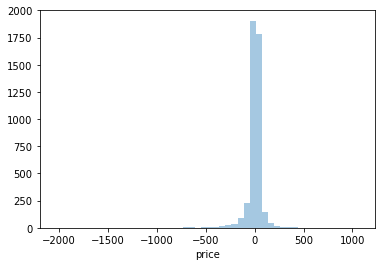

In [107]:
sns.distplot(residuals,kde=False)

###  Getting dummy varaibles and tranformation varaibles for random forest


In [108]:
data_dummy=pd.get_dummies(data,prefix_sep="@",columns=['area_type','society','location'],drop_first=True)

In [109]:
X=data_dummy.drop('price',axis=1)
y=pd.Series(np.log(data_dummy['price']))

In [110]:
X['total_sqft']=np.sqrt(data['total_sqft'])
X['size']=np.log(data['size'])
X['availability']=np.sqrt(data['availability'])
X['bath']=np.log(data['bath'])
X['balcony']=np.sqrt(data['balcony'])

### Train test split

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Applying Random Forest Regressor

In [112]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(n_estimators=100)
rfr.fit(X_train,y_train)

RandomForestRegressor()

In [113]:
from sklearn.metrics import mean_squared_error

In [114]:
pred=rfr.predict(X_test)


In [115]:
pred=np.e**pred

In [116]:
pred

array([ 61.13214612,  56.22538812, 106.0088892 , ...,  51.56862776,
        56.63920013, 100.81165908])

In [117]:
y_test=np.e**y_test

In [118]:
MAPE(y_test,pred)

21.970732642552413

In [119]:
np.sqrt(mean_squared_error(y_test,pred))

92.30604971208021

In [120]:
r2_score(y_test,pred)

0.6234467580679183

In [121]:
features=pd.DataFrame([X_train.columns,rfr.feature_importances_]).T

In [122]:
#top 10 features influencing the price of houses
features.sort_values(by=1,ascending=False).head(10)

,0,1
2,total_sqft,0.618303
3,bath,0.09979
1,size,0.0519619
6,area_type@Plot Area,0.0186632
4,balcony,0.00943594
0,availability,0.00917393
3638,location@Rajaji Nagar,0.00586365
2668,society@unknown,0.00534997
7,area_type@Super built-up Area,0.00412161
3450,location@Malleshwaram,0.0039418


# Conclusions

1) Random forest regressor gave us the best R squared of around 62 percent as comapared to polynomial regression(51.4%) and linear regression

2)Top 3 varaibles that affect the price of the houses are total square foot area,number of  bathrooms and number of bedrooms 

3)The area type - Plot area is a  major influencer for the price followed by number of balconies in the house

4)The data is highly skewed and this has affected the accuracy( R squared) of the model
